<a href="https://colab.research.google.com/github/AdsonRamos/if697-2020.2/blob/main/Projeto_2_Ci%C3%AAncia_de_dados_IF697.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando dependências

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

Carregando dados

In [102]:
customers = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_customers_dataset.csv", encoding="ISO-8859-1")
geolocation = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_geolocation_dataset.csv", encoding="ISO-8859-1")
order_items = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_order_items_dataset.csv", encoding="ISO-8859-1")
order_payments = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_order_payments_dataset.csv", encoding="ISO-8859-1")
order_reviews = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_order_reviews_dataset.csv", encoding="ISO-8859-1")
orders = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_orders_dataset.csv", encoding="ISO-8859-1")
products = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_products_dataset.csv", encoding="ISO-8859-1")
sellers = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/ecommerce/olist_sellers_dataset.csv", encoding="ISO-8859-1")

In [103]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [104]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [105]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [106]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,ParabÃ©ns lojas lannister adorei comprar pela ...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [107]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [108]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Para fazermos nossa predição, vamos unir as tabelas de produtos e de itens de pedido. No entanto, como há diferentes valores de order_item_id, price e freigh_value a tabela resultante terá linhas repetidas. Para resolver esse impasse, vamos pegar os registros da tabela que tenha uma única ocorrência de product_id.

In [109]:
product_itens = pd.merge(products, order_items, on='product_id')

In [110]:
product_itens_unique_id = product_itens['product_id'].value_counts()[product_itens['product_id'].value_counts() == 1].index

In [111]:
product_itens = product_itens[product_itens.product_id.isin(product_itens_unique_id)]

In [112]:
product_itens

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_id,order_item_id,seller_id,shipping_limit_date,price,freight_value
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,e17e4f88e31525f7deef66779844ddce,1,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,5236307716393b7114b53ee991f36956,1,b561927807645834b59ef0d16ba55a24,2018-02-06 19:11:15,248.00,17.99
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,01f66e58769f84129811d43eefd187fb,1,7b07b3c7487f0ea825fc6df75abd658b,2018-07-11 21:30:20,79.80,7.82
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,143d00a4f2dde4e0364ee1821577adb3,1,c510bc1718f0f2961eaa42a23330681a,2018-08-07 09:10:13,112.30,9.54
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,86cafb8794cb99a9b1b77fc8e48fbbbb,1,0be8ff43f22e456b4e0371b2245e4d01,2018-04-17 01:30:23,37.90,8.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112573,4508e088c4a07e0ad64f6fa3751e314a,esporte_lazer,45.0,1931.0,1.0,330.0,24.0,20.0,16.0,af6cf105471a4c8fc88ae0af594fde44,1,c3cfdc648177fdbbbb35635a37472c53,2017-07-10 15:03:57,76.90,15.30
112584,6ec96c91757fad0aecafc0ee7f262dcc,bebes,62.0,1417.0,1.0,9550.0,36.0,35.0,35.0,7c84f3ad69b989de803692b81743e3e7,1,20611af7866c6068fd5ae1f9dbe15c92,2018-07-19 20:25:12,109.90,57.25
112585,16280ca280a86fee2ba3c928ed04439f,moveis_decoracao,64.0,236.0,11.0,2200.0,31.0,11.0,26.0,668806d98daef95d0b00c461c8c4afc3,1,391fc6631aebcf3004804e51b40bcf1e,2017-04-11 08:15:14,89.90,12.02
112590,1a14237ecc2fe3772b55c8d4e11ccb35,moveis_decoracao,58.0,1405.0,3.0,150.0,35.0,2.0,25.0,96b4ac4e2ffc8baf3231dec72926b913,1,79ebd9a61bac3eaf882805ed4ecfa12a,2018-05-03 21:52:34,14.90,42.52


Vamos dropar as colunas order_id, order_item_id, seller_id

In [113]:
product_itens = product_itens.drop(['order_id', 'order_item_id', 'seller_id'], axis=1)

In [114]:
product_itens.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,shipping_limit_date,price,freight_value
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,2018-04-30 17:33:54,10.91,7.39
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,2018-02-06 19:11:15,248.00,17.99
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,2018-07-11 21:30:20,79.80,7.82
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,2018-08-07 09:10:13,112.30,9.54
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,2018-04-17 01:30:23,37.90,8.29


Vamos adicionar a coluna volume ao dataframe, cuja definição é o produto da altura x largura x comprimento.

In [115]:
product_itens['volume_cm3'] = product_itens['product_height_cm'] * product_itens['product_width_cm'] * product_itens['product_length_cm']

Vamos verificar a relação do peso do produto com o preço do mesmo

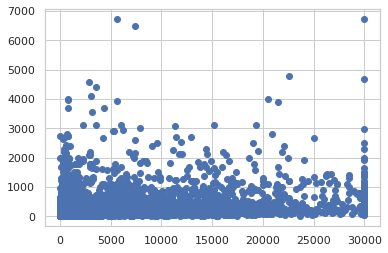

In [116]:
plt.scatter(product_itens['product_weight_g'], product_itens['price'])

Como os dados estão muito concentrados, vamos analisar uma categoria especifica, a fim de se obter melhores resultados na regressão. Escolhemos a categoria perfumaria.

In [117]:
product_itens['product_category_name'].value_counts()

cama_mesa_banho                  1594
esporte_lazer                    1533
moveis_decoracao                 1492
beleza_saude                     1328
automotivo                       1270
                                 ... 
casa_conforto_2                     4
fashion_roupa_infanto_juvenil       3
tablets_impressao_imagem            2
seguros_e_servicos                  2
pc_gamer                            1
Name: product_category_name, Length: 72, dtype: int64

In [118]:
perfumery = product_itens[product_itens['product_category_name'] == 'perfumaria']

In [119]:
perfumery.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,shipping_limit_date,price,freight_value,volume_cm3
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,2018-04-30 17:33:54,10.91,7.39,2240.0
232,b1eae565a61935e0011ee7682fef9dc9,perfumaria,49.0,460.0,2.0,267.0,17.0,13.0,17.0,2017-05-08 07:22:36,399.90,16.97,3757.0
324,8da90b37f0fb171b4877c124f965b1f6,perfumaria,56.0,733.0,3.0,377.0,18.0,13.0,15.0,2017-12-04 16:31:06,137.90,17.41,3510.0
446,828fe032935d7c1901682e5b6cc076c2,perfumaria,48.0,1063.0,2.0,600.0,20.0,20.0,20.0,2017-08-10 16:50:07,99.80,14.45,8000.0
859,cd7701670288642f7be9437dec9034c1,perfumaria,48.0,606.0,2.0,400.0,16.0,20.0,15.0,2017-12-21 23:56:27,99.99,15.45,4800.0


Vamos agora analizar qual conjunto de dados melhor se adquará ao modelo de regressão.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

100


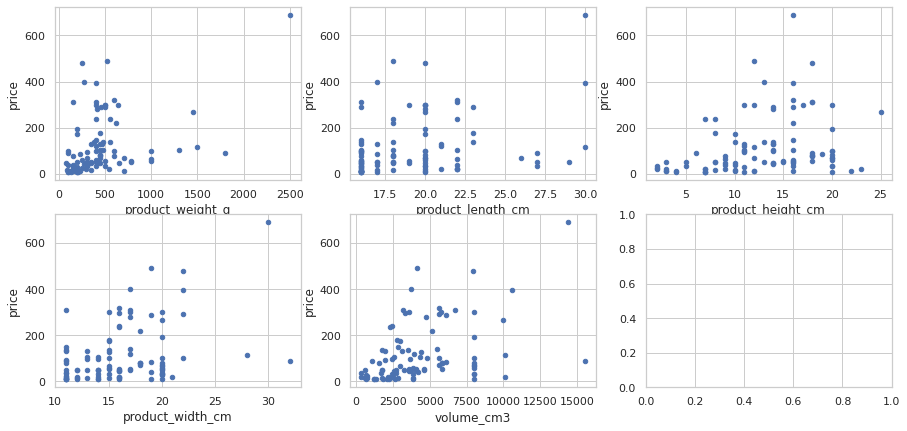

In [120]:
perfumery = perfumery[:100]
print(len(perfumery))
figs, axes = plt.subplots(2,3,figsize=(15,7))
perfumery[['product_weight_g', 'price']].plot.scatter(x = 'product_weight_g', y = 'price', ax = axes[0,0])
perfumery[['product_length_cm', 'price']].plot.scatter(x = 'product_length_cm', y = 'price', ax = axes[0,1])
perfumery[['product_height_cm', 'price']].plot.scatter(x = 'product_height_cm', y = 'price', ax = axes[0,2])
perfumery[['product_width_cm', 'price']].plot.scatter(x = 'product_width_cm', y = 'price', ax = axes[1,0])
perfumery[['volume_cm3', 'price']].plot.scatter(x = 'volume_cm3', y = 'price', ax = axes[1,1])

# Regressão Linear

Vamos aplicar o modelo de Regressão Linear ao conjunto de dados volume_cm3 x price

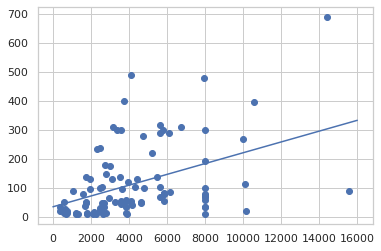

In [121]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(perfumery['volume_cm3'].values.reshape(-1, 1), perfumery['price'].values.reshape(-1, 1))

xfit = np.linspace(0, 16000, 4000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(perfumery['volume_cm3'], perfumery['price'])
plt.plot(xfit, yfit)

Avaliando métricas de desempenho

In [122]:
print("Model inclinação:      {:.3f}".format(model.coef_[0][0]))
print("Model intercepto:     {:.3f}".format(model.intercept_[0]))

Model inclinação:      0.019
Model intercepto:     35.134


MSE e R2 Score

In [124]:
from sklearn.metrics import r2_score, mean_squared_error

l = lambda x: model.coef_[0][0]*x + model.intercept_[0]

mse = mean_squared_error(perfumery['price'], l(perfumery['volume_cm3']))
r2 = r2_score(perfumery['price'], l(perfumery['volume_cm3']))

In [125]:
print("R2 l1:      {:.3f}".format(r2))
print("MSE l3:      {:.3f}".format(mse))

R2 l1:      0.184
MSE l3:      12742.401


Vamos verificar os resíduos com o ajuste da curva

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


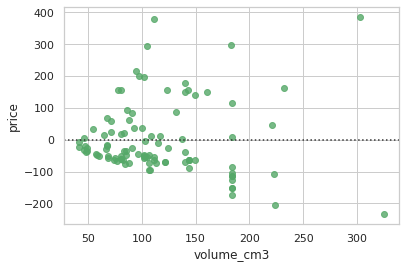

In [126]:
sns.set(style="whitegrid")

# Plotando os resíduos após utilizar a regressão linear
sns.residplot(l(perfumery['volume_cm3']), perfumery['price'], color="g")

# Regressão Linear Múltipla

Vamos utilizar agora **Regressão Linear múltipla**. Usaremos os parâmetros product_weight_g, product_length_cm, product_height_cm, product_width_cm, volume_cm3 para prever a variável preço.

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(perfumery[['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'volume_cm3']], perfumery.price)

print('y = {:.3f} {:+.3f}x1 {:+.3f}x2 {:+.3f}x3 {:+.3f}x4 {:+.3f}x5'\
           .format(model.intercept_, model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3], model.coef_[4]))

In [ ]:
perfumery[['product_id', 'price']]

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor()
regr.fit(perfumery[['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'volume_cm3']], perfumery.price)

In [ ]:
predict = regr.predict(perfumery[['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'volume_cm3']])

mse = mean_squared_error(perfumery.price, predict)
r2 = r2_score(perfumery.price, predict)

print("R2:      {:.3f}".format(r2))
print("MSE:     {:.3f}".format(mse))

sns.set(style="whitegrid")
sns.residplot(predict, perfumery.price, color="g")